In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
import os
import glob
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

DATA_DIR = "/content/drive/MyDrive/data"
SELECTED_ACTIVITIES = ["sit", "walk", "run", "stairs"]


TRAIN_POSITIONS = ["dom_hand"]
TEST_POSITIONS = ["nondom_hand"]

SAMPLING_RATE = 100
TRIM_SECONDS = 2
WINDOW_SIZE = SAMPLING_RATE
STEP_SIZE = SAMPLING_RATE // 2

BATCH_SIZE = 32
EPOCHS = 100
LR = 0.001
DROPOUT = 0.3
RANDOM_STATE = 42

RAW_FEATURES = ["ax", "ay", "az", "gx", "gy", "gz"]
GFT_FEATURES = ["ax_g", "ay_g", "az_g", "gx_g", "gy_g", "gz_g"]

np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

In [16]:
def load_selected_csvs(base_dir):
    dfs = []

    all_needed_positions = list(set(TRAIN_POSITIONS + TEST_POSITIONS))

    for activity in SELECTED_ACTIVITIES:
        for position in all_needed_positions:
            path = os.path.join(base_dir, activity, position, "*.csv")
            for csv_path in glob.glob(path):
                try:
                    df = pd.read_csv(csv_path)
                    df["activity"] = activity
                    df["phone_position"] = position
                    df["recording_id"] = os.path.splitext(os.path.basename(csv_path))[0]
                    dfs.append(df)
                except Exception as e:
                    print(f"Error loading {csv_path}: {e}")

    print(f"Loaded {len(dfs)} recordings in total.")
    return dfs

def trim_df(df):
    trim = SAMPLING_RATE * TRIM_SECONDS
    if len(df) <= 2 * trim:
        return None
    return df.iloc[trim:-trim].reset_index(drop=True)

def sliding_windows(df):
    for start in range(0, len(df) - WINDOW_SIZE + 1, STEP_SIZE):
        yield df.iloc[start:start + WINDOW_SIZE]

def build_dataset(dfs, feature_cols):
    X, y, groups = [], [], []
    for df in dfs:
        df = trim_df(df)
        if df is None:
            continue
        for w in sliding_windows(df):
            X.append(w[feature_cols].values)
            y.append(w["activity"].iloc[0])
            groups.append(w["recording_id"].iloc[0])

    if len(X) == 0:
        return np.array([]), np.array([]), np.array([])

    X = np.array(X)
    y = np.array(y)
    groups = np.array(groups)
    return X, y, groups

class MotionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [17]:
class DeepConvLSTM(nn.Module):
    def __init__(self, input_features, num_classes, dropout=0.3):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(input_features, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.MaxPool1d(2),

            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.lstm = nn.LSTM(
            input_size=256,
            hidden_size=128,
            num_layers=2,
            batch_first=True,
            dropout=dropout
        )
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv(x)
        x = x.permute(0, 2, 1)
        x, _ = self.lstm(x)
        x = x.permute(0, 2, 1)
        x = self.global_pool(x).squeeze(-1)
        return self.fc(x)

In [20]:
def run_training(X_train, y_train, X_val, y_val, num_classes):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_loader = DataLoader(MotionDataset(X_train, y_train),
                              batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(MotionDataset(X_val, y_val),
                            batch_size=BATCH_SIZE, shuffle=False)

    model = DeepConvLSTM(
        input_features=X_train.shape[2],
        num_classes=num_classes,
        dropout=DROPOUT
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, factor=0.5, patience=10
    )

    best_loss = np.inf
    best_state = None

    print(f"Starting training on {len(X_train)} samples, validating on {len(X_val)} samples...")

    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                out = model(xb)
                val_loss += criterion(out, yb).item() * xb.size(0)

        val_loss /= len(val_loader.dataset)
        scheduler.step(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_state = model.state_dict()

        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{EPOCHS} - Val Loss: {val_loss:.4f}")

    print("Training complete. Loading best model.")
    model.load_state_dict(best_state)
    return model

def run_cross_position_experiment(all_dfs, feature_cols, title_suffix):
    print(f"\n{'='*20}\nRunning: {title_suffix}\n{'='*20}")

    train_dfs = [df for df in all_dfs if df["phone_position"].iloc[0] in TRAIN_POSITIONS]
    test_dfs = [df for df in all_dfs if df["phone_position"].iloc[0] in TEST_POSITIONS]

    print(f"Training DataFrames: {len(train_dfs)} (Positions: {TRAIN_POSITIONS})")
    print(f"Testing DataFrames:  {len(test_dfs)} (Positions: {TEST_POSITIONS})")

    if not train_dfs or not test_dfs:
        print("Error: Missing data for either train or test positions.")
        return

    print("Building Training Dataset...")
    X_full_train, y_full_train, g_full_train = build_dataset(train_dfs, feature_cols)

    print("Building Testing Dataset...")
    X_test, y_test, _ = build_dataset(test_dfs, feature_cols)

    if len(X_full_train) == 0 or len(X_test) == 0:
        print("Error: Not enough data after windowing.")
        return

    le = LabelEncoder()
    le.fit(SELECTED_ACTIVITIES)

    y_full_train_enc = le.transform(y_full_train)
    y_test_enc = le.transform(y_test)

    scaler = StandardScaler()

    N, T, F = X_full_train.shape
    X_train_flat = X_full_train.reshape(-1, F)
    scaler.fit(X_train_flat)

    X_full_train = scaler.transform(X_train_flat).reshape(N, T, F)

    N_test, T_test, F_test = X_test.shape
    X_test = scaler.transform(X_test.reshape(-1, F_test)).reshape(N_test, T_test, F_test)
    splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_STATE)
    train_idx, val_idx = next(splitter.split(X_full_train, y_full_train_enc, g_full_train))

    X_train = X_full_train[train_idx]
    y_train = y_full_train_enc[train_idx]
    X_val = X_full_train[val_idx]
    y_val = y_full_train_enc[val_idx]

    model = run_training(X_train, y_train, X_val, y_val, num_classes=len(le.classes_))

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    test_loader = DataLoader(MotionDataset(X_test, y_test_enc), batch_size=BATCH_SIZE, shuffle=False)

    preds, trues = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            out = model(xb)
            preds.extend(out.argmax(1).cpu().numpy())
            trues.extend(yb.numpy())

    print(f"\n=== Classification Report: {title_suffix} ===")
    print(f"Train Pos: {TRAIN_POSITIONS}")
    print(f"Test Pos:  {TEST_POSITIONS}")
    print(classification_report(trues, preds, target_names=le.classes_, digits=4))

    cm = confusion_matrix(trues, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=le.classes_,
                yticklabels=le.classes_,
                cmap="Blues")
    plt.title(f"{title_suffix}\nTrain: {TRAIN_POSITIONS} -> Test: {TEST_POSITIONS}")
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()

Loaded 40 recordings in total.

Running: DeepConvLSTM (RAW)
Training DataFrames: 20 (Positions: ['dom_hand'])
Testing DataFrames:  20 (Positions: ['nondom_hand'])
Building Training Dataset...
Building Testing Dataset...
Starting training on 803 samples, validating on 202 samples...
Epoch 10/100 - Val Loss: 0.1083
Epoch 20/100 - Val Loss: 0.0925
Epoch 30/100 - Val Loss: 0.1515
Epoch 40/100 - Val Loss: 0.1137
Epoch 50/100 - Val Loss: 0.0775
Epoch 60/100 - Val Loss: 0.0829
Epoch 70/100 - Val Loss: 0.0887
Epoch 80/100 - Val Loss: 0.1087
Epoch 90/100 - Val Loss: 0.1140
Epoch 100/100 - Val Loss: 0.0790
Training complete. Loading best model.

=== Classification Report: DeepConvLSTM (RAW) ===
Train Pos: ['dom_hand']
Test Pos:  ['nondom_hand']
              precision    recall  f1-score   support

         run     0.3027    1.0000    0.4647       250
         sit     0.9941    0.6760    0.8048       250
      stairs     1.0000    0.0275    0.0534       255
        walk     0.0000    0.0000    0

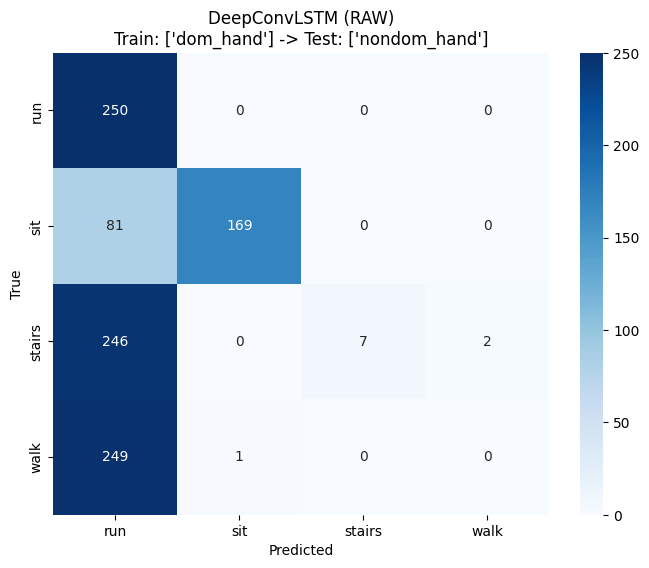


Running: DeepConvLSTM (GFT)
Training DataFrames: 20 (Positions: ['dom_hand'])
Testing DataFrames:  20 (Positions: ['nondom_hand'])
Building Training Dataset...
Building Testing Dataset...
Starting training on 803 samples, validating on 202 samples...
Epoch 10/100 - Val Loss: 0.2229
Epoch 20/100 - Val Loss: 0.0911
Epoch 30/100 - Val Loss: 0.1801
Epoch 40/100 - Val Loss: 0.0963
Epoch 50/100 - Val Loss: 0.1219
Epoch 60/100 - Val Loss: 0.1318
Epoch 70/100 - Val Loss: 0.0779
Epoch 80/100 - Val Loss: 0.1005
Epoch 90/100 - Val Loss: 0.0882
Epoch 100/100 - Val Loss: 0.1310
Training complete. Loading best model.

=== Classification Report: DeepConvLSTM (GFT) ===
Train Pos: ['dom_hand']
Test Pos:  ['nondom_hand']
              precision    recall  f1-score   support

         run     0.8129    0.9040    0.8561       250
         sit     0.7645    1.0000    0.8666       250
      stairs     0.6667    0.0078    0.0155       255
        walk     0.4685    0.7440    0.5750       250

    accuracy  

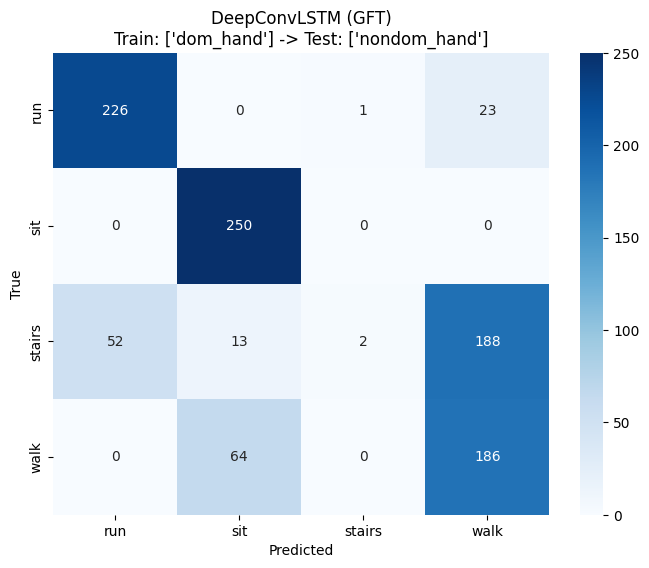

In [21]:
if __name__ == "__main__":

    all_recordings = load_selected_csvs(DATA_DIR)

    if not all_recordings:
        print("No CSV files found. Check DATA_DIR.")
    else:
        run_cross_position_experiment(all_recordings, RAW_FEATURES, "DeepConvLSTM (RAW)")

        run_cross_position_experiment(all_recordings, GFT_FEATURES, "DeepConvLSTM (GFT)")